<a href="https://colab.research.google.com/github/adihebbalae/adihebbalae-MusicRecommenders/blob/main/Section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import gdown
import sys

# new dependencies
!pip --disable-pip-version-check install requests==2.27.1
!pip --disable-pip-version-check install urllib3
!pip --disable-pip-version-check install spotipy --upgrade
!pip --disable-pip-version-check  install traces

import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
import traces

# do not change these codes
client_credentials_manager = SpotifyClientCredentials('e316c18604cb42399f3b679791362112','4bd95a0d37d145998cfdcaf2a68579d7')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# machine learning models
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#warning supression
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


# audio analysis
import librosa
import librosa.display
!pip install audio2numpy
!apt-get install ffmpeg
import audio2numpy
import IPython.display as ipd

# helper function to plot a timbre timecourse
def plot_timbre(df, song_id, timbre_col):
    col = f'timbre_{timbre_col}'
    plt.figure()
    plt.plot([i*.5 for i in range(len(df[col][song_id]))], df[col][song_id])
    plt.xlabel('time/seconds')
    plt.ylabel('timbre component weight')

# timbre timecourses
# data_url = 'https://drive.google.com/uc?id=1jwG1B98Uq5phurfGmdZg8w2BCJdth6Io'
!wget -O ./spotify_data_timbre.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_timbre.csv'
data_path = './spotify_data_timbre.csv'
# gdown.download(data_url, data_path , True)

# chirp file
# chirp_url = 'https://drive.google.com/uc?id=1iX6wV0cSGIVM0nTItTSUlUehhKCILymB'
!wget -O ./chirp.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/chirp.wav'
chirp_path = './chirp.wav'
# gdown.download(chirp_url, chirp_path , True)

# two wav files
# wav1_url = 'https://drive.google.com/uc?id=14qA48pPVJKU4KlP8YwqTpDo7WEewjXwf'
!wget -O ./wav1_path.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3504.wav'
wav1_path = './sample1.wav'
# gdown.download(wav1_url, wav1_path , True)

# wav2_url = 'https://drive.google.com/uc?id=12XIWhMCAiabzGqXQhN2wB9o5p6MFR4Y0'
!wget -O ./wav2_path.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3642.wav'
wav2_path = './sample2.wav'
# gdown.download(wav2_url, wav2_path , True)

# Check that the data downloaded by running this cell! It'll have more columns than usual.
data = pd.read_csv(data_path)
data.rename(columns={'Unnamed: 0':'orig_index'},inplace=True)
data.drop(columns=['index'],inplace=True)

In [ ]:
def string_to_list(input_string):
    output_list = []
    new_list = []
    #### YOUR CODE HERE ####
    output_list = input_string[1:-1].split(', ')
    for i in output_list:
      new_list.append(float(i))
    #### END CODE ####
    return new_list

# some tests to see if your code worked
test_input = '[5, 12.3, 3.3, 9.7]'
print(string_to_list(test_input))
print(type(string_to_list(test_input)))

[5.0, 12.3, 3.3, 9.7]
<class 'list'>


In [ ]:
for i in range(1,13): # note we need to go from 1 to 13 since range leaves out the last number
    column = 'timbre_' + str(i)
    if type(data[column][0]) == str: # this means that if we rerun the cell accidentally it won't break!
        data[column] = data[column].apply(string_to_list)

data.head()

,orig_index,Artist,Track,Year,url,Label,duration,timbre_1,timbre_2,timbre_3,timbre_4,timbre_5,timbre_6,timbre_7,timbre_8,timbre_9,timbre_10,timbre_11,timbre_12
0,0,intonation featuring joee,died in your arms,2009,https://open.spotify.com/track/0AAMVuVqJnW4PVZ...,1,280.160,"[0.0, 31.93096608872048, 35.389407422975076, 3...","[171.13, 79.98731220576416, 75.74027308646127,...","[9.469, 123.5155301412332, 114.41647005170022,...","[-28.48, -14.00211562751177, 11.83176659240889...","[57.491, 99.35745707505646, 90.77753852297087,...","[-50.067, 25.58930474222069, -10.5464018326257...","[14.833, -30.858398706319136, -42.033517170358...","[5.359, -11.803781528686798, -10.8885563028035...","[-27.228, -25.220395644352585, -25.79008238409...","[0.973, 6.293402572051898, -9.005808583077636,...","[-10.64, 14.310292379530752, -1.31420772561052...","[-7.228, -0.02460263329123258, 8.5397953427766..."
1,1,jack johnson,monsoon,2008,https://open.spotify.com/track/7s4qhv3Txiv4oFW...,0,256.813,"[2.998, 19.65953469052869, 12.744096217650963,...","[103.425, -202.65228065227424, -75.61390510948...","[-58.005, -124.09351766576073, -123.3319800928...","[-58.624, -57.981803958771344, 7.4363185136031...","[37.678, 86.39224106456079, 68.92994625082946,...","[-46.392, -52.425471052766525, -51.88967551426...","[-9.681, -13.297634685400748, -26.091938287989...","[1.02, 29.404950515358188, 106.34929794293298,...","[-33.359, -19.202246192502948, -5.323623092236...","[2.376, -3.9448509820009234, -5.94654147312540...","[-5.873, -5.535454386954515, 4.142536828135369...","[-0.558, 6.421904312599354, -3.052210351692103..."
2,2,kapelle herrenweide,humppa,2009,https://open.spotify.com/track/7kZQxHjiHHf6Kqy...,0,258.346,"[1.651, 43.63666528403967, 44.80971266769758, ...","[153.244, 58.93194517583409, 55.15626104400886...","[20.856, -27.760677006311994, -0.9223222719103...","[-68.876, 71.00899765554554, 61.50337614410497...","[46.952, 6.437235166816954, -6.601664479458352...","[-61.662, 51.948587015329124, 15.9049562419024...","[30.292, 30.001814247069433, 25.23144305596188...","[-28.44, -19.782593507664565, -18.267860241568...","[-29.136, -43.0516872858431, -39.7837204831362...","[1.536, 20.711096302975655, -9.602437706356834...","[16.413, -22.591161226330026, -17.839150666610...","[-8.823, 19.360109107303877, 14.08162067956701..."
3,3,2 minutos,rompan todo,2007,https://open.spotify.com/track/4RrFTURDPtSQcbZ...,0,88.586,"[1.093, 51.130689943510035, 52.74655313008504,...","[156.545, 52.262964861328314, 33.7868968714500...","[25.101, 66.05149538824881, 24.51923926192011,...","[-54.729, -50.21109504356429, -9.7744942740474...","[56.904, 0.10991896722305494, -25.195918117343...","[-60.126, -11.785241311077778, -16.25799591661...","[26.202, 31.08373092266939, 32.918958030149525...","[-25.347, 24.86705913892701, 10.52566178502349...","[-30.721, -14.403229598187213, -14.19191108654...","[-4.711, 8.364651230332237, 6.013853673513248,...","[13.125, -10.645196151022883, 2.13488366952197...","[-10.526, -1.9825545910062878, -0.156492094194..."
4,4,sonora carruseles,la chola caderona,2015,https://open.spotify.com/track/4lFHxhQGDhRbfYe...,0,295.306,"[0.0, 38.675149685878175, 50.917856753023614, ...","[171.13, -47.33685659655833, 61.13510342620351...","[9.469, -8.687915596831491, 5.171144089209324,...","[-28.48, 103.47913602840754, -7.81937721928369...","[57.491, 9.400311663479915, -6.473240844928036...","[-50.067, -75.22705845397432, -6.7019374389381...","[14.833, -46.940350996995335, 1.90458376848699...","[5.359, -7.027439770554484, 15.520397466563324...","[-27.228, -21.236274515159792, -7.974969140585...","[0.973, -0.2617473367932267, 3.847741737694988...","[-10.64, -17.457464354001633, 12.9524641040325...","[-7.228, 2.9048615132477447, 18.35614995115049..."


The dataframe basically looks the same, but it actually contains lists instead of strings now.

It might be cool to see what some timbre timecourses look like for a particular song. We can use the `plot_timbre` function which takes three parameters: the data, the song index, and the component number.

The code below plots the timbre timecourse of component 3 for the song at index 0 in the dataset.

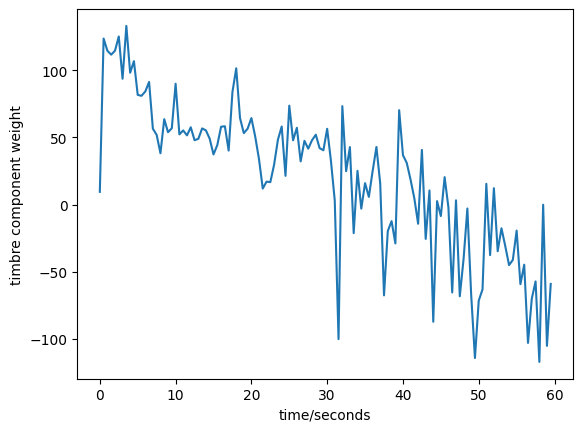

In [ ]:
plot_timbre(data, 0, 3)

In [ ]:
n_timbres = 12 # this is the number of timbre components
n_timesteps = 120 # this is the number of timesteps we're interested in

for i in range(1,n_timbres+1):
    exploded_cols = []
    for t in range(n_timesteps):
        new_column_title = 'timbre_' + str(i) + '_' + str(t) # this gets us the column title we need
        exploded_cols.append(new_column_title)
    # now, let's generate the new columns
    data[exploded_cols] = pd.DataFrame(data['timbre_' + str(i)].to_list(), index=data.index)

In [ ]:
data.head()

,orig_index,Artist,Track,Year,url,Label,duration,timbre_1,timbre_2,timbre_3,...,timbre_12_110,timbre_12_111,timbre_12_112,timbre_12_113,timbre_12_114,timbre_12_115,timbre_12_116,timbre_12_117,timbre_12_118,timbre_12_119
0,0,intonation featuring joee,died in your arms,2009,https://open.spotify.com/track/0AAMVuVqJnW4PVZ...,1,280.160,"[0.0, 31.93096608872048, 35.389407422975076, 3...","[171.13, 79.98731220576416, 75.74027308646127,...","[9.469, 123.5155301412332, 114.41647005170022,...",...,5.747648,-9.033312,-6.249918,-2.200340,-23.149632,-24.397224,15.664995,-7.425312,-4.848591,0.929415
1,1,jack johnson,monsoon,2008,https://open.spotify.com/track/7s4qhv3Txiv4oFW...,0,256.813,"[2.998, 19.65953469052869, 12.744096217650963,...","[103.425, -202.65228065227424, -75.61390510948...","[-58.005, -124.09351766576073, -123.3319800928...",...,3.791805,-5.079529,-8.855646,-10.307518,10.689436,6.177778,-15.560173,-2.890256,6.928514,-10.078932
2,2,kapelle herrenweide,humppa,2009,https://open.spotify.com/track/7kZQxHjiHHf6Kqy...,0,258.346,"[1.651, 43.63666528403967, 44.80971266769758, ...","[153.244, 58.93194517583409, 55.15626104400886...","[20.856, -27.760677006311994, -0.9223222719103...",...,-12.017697,16.059680,4.756968,-6.614615,-4.795254,-0.113060,-12.266024,-1.302216,-3.263997,-14.784442
3,3,2 minutos,rompan todo,2007,https://open.spotify.com/track/4RrFTURDPtSQcbZ...,0,88.586,"[1.093, 51.130689943510035, 52.74655313008504,...","[156.545, 52.262964861328314, 33.7868968714500...","[25.101, 66.05149538824881, 24.51923926192011,...",...,-5.674484,-12.784451,-2.597172,3.595489,9.819566,-17.290625,-6.151195,5.837999,-12.961413,-14.434939
4,4,sonora carruseles,la chola caderona,2015,https://open.spotify.com/track/4lFHxhQGDhRbfYe...,0,295.306,"[0.0, 38.675149685878175, 50.917856753023614, ...","[171.13, -47.33685659655833, 61.13510342620351...","[9.469, -8.687915596831491, 5.171144089209324,...",...,9.889077,-7.827933,6.410276,5.864406,1.873198,-26.939129,0.562737,-4.965123,-3.857713,9.032431


In [ ]:
### YOUR CODE HERE
data.drop(index=np.where(data['timbre_1_119'].isnull())[0],inplace=True)

In [ ]:
data.shape

(952, 1459)

In [ ]:
timbre_cols = [f'timbre_{i}_{j}' for i in range(1,n_timbres+1) for j in range(1,n_timesteps)]

### TODO: Modify this code
X = data[timbre_cols]
y = data['Label']

# TODO: add your train/test split code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

models = [LogisticRegression(),
          SVC(),
          KNeighborsClassifier(),
          GaussianNB(),
          MLPClassifier(hidden_layer_sizes=(100,10))]
model_names = [type(model).__name__ for model in models]

model_scores = []

### TODO: Modify this code
for model in models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_scores.append(score)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


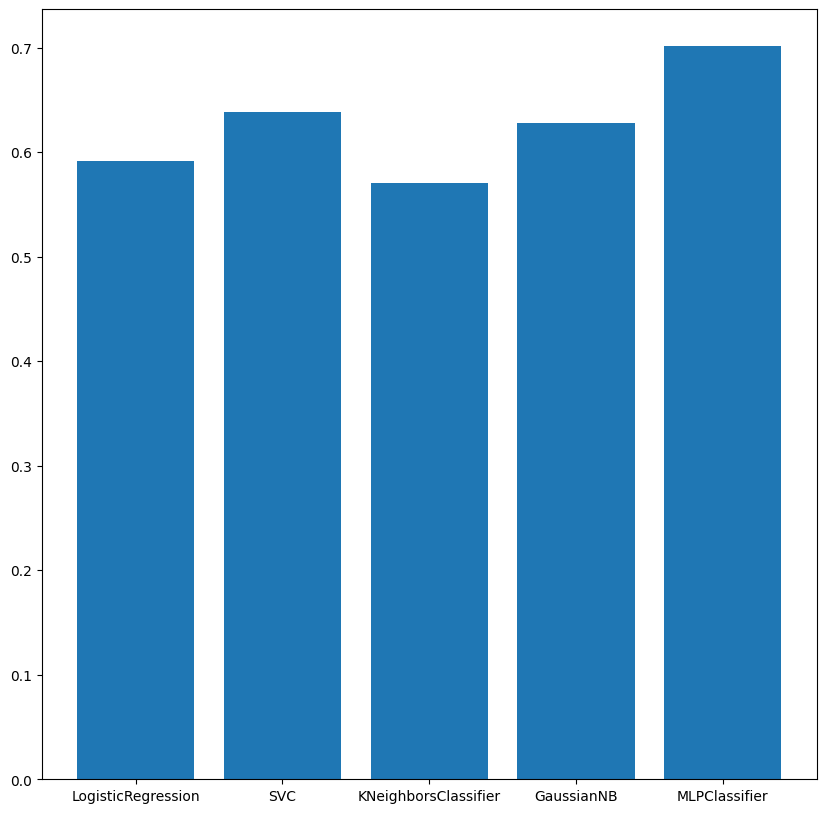

In [ ]:
model_scores
plt.figure(figsize=(10,10))
plt.bar(model_names, model_scores)
plt.show()

In [ ]:
cols = ['timbre_' + str(i) for i in range(1,n_timbres+1)]
all_songs = []
for s in range(len(data)): # for every song in the dataframe
    song_timbre_vectors = []
    for t in range(n_timesteps): # for each timestep
        # let's now make a list of the timbre components for song s at timestep t
        time_t_timbres = [data[col].iloc[s][t] for col in cols]
        # now let's add it to our song_timbre_vectors_list
        song_timbre_vectors.append(time_t_timbres)
    # now let's add that song's timbre vectors to the all_songs list
    all_songs.append(song_timbre_vectors)

# finally, convert this to a matrix.
X_new = np.array(all_songs)

In [ ]:
print(X_new.shape)

(952, 120, 12)


In [ ]:
y_new = np.array(y)
y_new.shape

(952,)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy

In [ ]:
# Build the model
## TODO: fill in the dimension sizes here
n_timesteps = 120
n_input = 12
n_output = 1

model = Sequential()
## TODO: Choose the number of neurons in the LSTM output.
model.add(LSTM(128, input_shape=(n_timesteps,n_input)))
## TODO: Choose the number of units in your dense hidden layer
model.add(Dense(100))
# Do you want more layers? Add them here!
model.add(Dense(10))
# Leave this one in
model.add(Dense(n_output))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 86,113
Trainable params: 86,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# new train-test split
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=.2, random_state=1)

model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

model.fit(
    X_new_train, y_new_train, validation_data=(X_new_test, y_new_test), batch_size=50, epochs=30
)


Epoch 1/30
16/16 [==============================] - 14s 553ms/step - loss: 0.7227 - accuracy: 0.5664 - val_loss: 0.6420 - val_accuracy: 0.6021
Epoch 2/30
16/16 [==============================] - 6s 343ms/step - loss: 0.5686 - accuracy: 0.6859 - val_loss: 0.6236 - val_accuracy: 0.5759
Epoch 3/30
16/16 [==============================] - 5s 345ms/step - loss: 0.4870 - accuracy: 0.7332 - val_loss: 0.6237 - val_accuracy: 0.6126
Epoch 4/30
16/16 [==============================] - 3s 191ms/step - loss: 0.4009 - accuracy: 0.7963 - val_loss: 0.6322 - val_accuracy: 0.6230
Epoch 5/30
16/16 [==============================] - 3s 197ms/step - loss: 0.3114 - accuracy: 0.8699 - val_loss: 0.6590 - val_accuracy: 0.6545
Epoch 6/30
16/16 [==============================] - 3s 192ms/step - loss: 0.2279 - accuracy: 0.8962 - val_loss: 0.7227 - val_accuracy: 0.6283
Epoch 7/30
16/16 [==============================] - 5s 294ms/step - loss: 0.1456 - accuracy: 0.9580 - val_loss: 0.7592 - val_accuracy: 0.6754
Epoch